In [ ]:
import torch
import torchvision
from torch.utils.tensorboard import SummaryWriter

In [ ]:
torch.cuda.is_available()

True

In [ ]:
print('ID of current CUDA device: ', torch.cuda.current_device())
print('Name of current CUDA device is: ', torch.cuda.get_device_name(torch.cuda.current_device()))
print('Amount of GPU memory allocated: ', torch.cuda.memory_allocated(torch.cuda.current_device()))
print('Amount of GPU memory reserved: ', torch.cuda.memory_reserved(torch.cuda.current_device()))

ID of current CUDA device:  0
Name of current CUDA device is:  Tesla T4
Amount of GPU memory allocated:  0
Amount of GPU memory reserved:  0


In [ ]:
# torch.cuda.empty_cache()

In [ ]:
print(torch.__version__)
print(torchvision.__version__)

1.7.0+cu101
0.8.1+cu101


In [ ]:
writer = SummaryWriter()

# Dataset

In [ ]:
torchvision.datasets.CIFAR10(root ='./',download = True)

Extracting ./cifar-10-python.tar.gz to ./



Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

In [ ]:
cifar10 = torchvision.datasets.CIFAR10(root='./')
cifar10

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ./
    Split: Train

# MobileNetV3 (small)

In [ ]:
import torch.nn as nn

In [ ]:
class hard_sigmoid(nn.Module):
    def __init__(self, inplace = True):
        super(hard_sigmoid, self).__init__()
        self.h_sig = nn.ReLU6(inplace = inplace)
    def forward(self, x):
        x = self.h_sig(x+ 3.) / 6
        return x

In [ ]:
class hard_swish(nn.Module):
    def __init__(self, inplace = True):
        super(hard_swish, self).__init__()
        self.h_sig = hard_sigmoid(inplace = inplace)
    def forward(self, x):
        x = x * self.h_sig(x)
        return x

In [ ]:
def conv_1x1_bn(input, output, activation = nn.ReLU):
    conv = nn.Sequential(
        nn.Conv2d(input, output, 1, 1, 0, bias = False),
        nn.BatchNorm2d(output),
        activation(inplace = True)
    )
    return conv

In [ ]:
def conv_3x3_bn(input, output, activation = nn.ReLU, stride = 2):
    conv = nn.Sequential(
        nn.Conv2d(input, output, 3, stride, 1, bias = False),
        nn.BatchNorm2d(output),
        activation()
    )
    return conv

In [ ]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction = 4, SE = False):
        super(SEBlock, self).__init__()
        self.SE = SE
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.se = SE
        self.exc_block = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias = False),
            nn.ReLU(inplace = True),
            nn.Linear(channel // reduction, channel, bias = False),
            hard_sigmoid()
        )
    def forward(self, x):
        if self.SE:
            b, c, _, _ = x.size()
            y = self.avg_pool(x).view(b,c)
            y = self.exc_block(y).view(b, c, 1,1)
            x = x *y.expand_as(x)
        return x

In [ ]:
class Bottleneck(nn.Module):
    def __init__(self, input, output, kernel, stride, exp_size, SE = False, act = 'RE'):
        super(Bottleneck, self).__init__()
        padding = (kernel - 1) // 2
        sq_ex = SE
        
        if stride == 1 and input == output:
            self.residual = True
        else:
            self.residual = False
            
        if act == 'RE':
            activation = nn.ReLU
        elif act == 'HS':
            activation = hard_swish
        
        self.conv = nn.Sequential(
            nn.Conv2d(input, exp_size, 1, 1, 0, bias = False),
            nn.BatchNorm2d(exp_size),
            activation(),
            nn.Conv2d(exp_size, exp_size, kernel, stride, padding, groups = exp_size, bias = False),
            nn.BatchNorm2d(exp_size),
            SEBlock(channel = exp_size, SE = sq_ex),
            activation(inplace = True),
            nn.Conv2d(exp_size, output, 1, 1, 0, bias = False),
            nn.BatchNorm2d(output)
        )
    def forward(self, x):
        if self.residual:
            x = x + self.conv(x)
        else:
            x = self.conv(x)
        return x

In [ ]:
class MobileNetV3(nn.Module):
    def __init__(self, input_size = 224):
        super(MobileNetV3, self).__init__()
        if input_size == 32:
            s = 1
        else:
            s = 2
        mobile_setting = [
                # k, exp, out,  se,     nl,  s,
                [3, 16,  16,  True,  'RE', s],
                [3, 72,  24,  False, 'RE', 2],
                [3, 88,  24,  False, 'RE', 1],
                [5, 96,  40,  True,  'HS', 2],
                [5, 240, 40,  True,  'HS', 1],
                [5, 240, 40,  True,  'HS', 1],
                [5, 120, 48,  True,  'HS', 1],
                [5, 144, 48,  True,  'HS', 1],
                [5, 288, 96,  True,  'HS', 2],
                [5, 576, 96,  True,  'HS', 1],
                [5, 576, 96,  True,  'HS', 1]]
        
        input_channel = 16
        self.net = [conv_3x3_bn(3, input_channel, activation = hard_swish)]
        
        for k, exp_size, out, se, nl, s in mobile_setting:
            output_channel = out
            self.net.append(Bottleneck(input_channel, output_channel, k, s, exp_size, se, nl))
            input_channel = output_channel
        self.net.append(conv_1x1_bn(input_channel, 576, activation = hard_swish))
        self.net.append(nn.AdaptiveAvgPool2d(1))
        self.net.append(nn.Conv2d(576, 1280, 1, 1, 0))
        self.net.append(hard_swish())
        
        self.net = nn.Sequential(*self.net)
        
        self.classifier= nn.Sequential(
            nn.Dropout(p = 0.8),
            nn.Flatten(),
            nn.Linear(1280, 10),
            nn.Softmax()
        )
    def forward(self, x):
        x = self.net(x)
        x = self.classifier(x)
        return x

In [ ]:
net = MobileNetV3(input_size = 224)

In [ ]:
input_size=(1, 3, 224, 224)

In [ ]:
x = torch.randn(input_size)
out = net(x)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [ ]:
out.shape

torch.Size([1, 10])

# Training preparation


In [ ]:
import os
from torch.optim import lr_scheduler
import torch.optim as optim
from torch.nn import DataParallel

In [ ]:
GPU = 0, 1

In [ ]:
gpu_list = ''
multi_gpus = False
if isinstance(GPU, int):
    gpu_list = str(GPU)
else:
    multi_gpus = True
    for i, gpu_id in enumerate(GPU):
        gpu_list += str(gpu_id)
        if i != len(GPU) - 1:
            gpu_list += ','
os.environ['CUDA_VISIBLE_DEVICES'] = gpu_list

In [ ]:
net = net.cuda()
if multi_gpus:
    net = DataParallel(net)

In [ ]:
from torchvision import transforms

In [ ]:
augment_normalize_train = transforms.Compose([transforms.Resize(224),
                                              transforms.RandomHorizontalFlip(),
                     transforms.ToTensor(),
                     transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))])

In [ ]:
trainset = torchvision.datasets.CIFAR10(root='./', train = True, transform = augment_normalize_train)

In [ ]:
augment_normalize_test = transforms.Compose([transforms.Resize(224),
                                             transforms.ToTensor(),
                     transforms.Normalize((0.5071, 0.4865, 0.4409), (0.2673, 0.2564, 0.2762))])

In [ ]:
testset = torchvision.datasets.CIFAR10(root='./', train = False, transform = augment_normalize_test)

In [ ]:
img, label = trainset[0]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def show(image):
    plt.figure(figsize=(5,5))
    plt.imshow(image)
    plt.show()

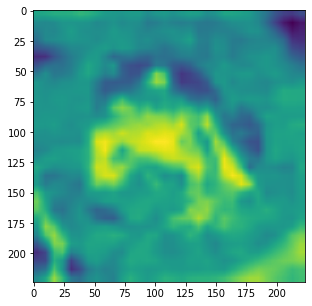

In [ ]:
show(img[0])

In [ ]:
label

6

In [ ]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=128,
                                          shuffle=True, num_workers=8, drop_last=False)

In [ ]:
testloader = torch.utils.data.DataLoader(testset, batch_size=128,
                                          shuffle=True, num_workers=8, drop_last=False)

# Training

In [ ]:
import time
from sklearn.metrics import f1_score, accuracy_score

In [ ]:
EPOCHS = 400

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=1e-1, momentum=0.9)
lr = lr_scheduler.StepLR(optimizer, step_size = 20, gamma=0.1)

In [ ]:
best_acc = 0.
for epoch in range(1, EPOCHS + 1):
    lr.step(epoch)
    start_train = time.time()
    
    print('Train Epoch: {}/{} ...'.format(epoch, EPOCHS))
    net.train()
    train_loss = 0.
    batches = 0
    for data in trainloader:
        images, labels = data[0].cuda(), data[1].cuda()
        
        optimizer.zero_grad()
        raw_logits = net(images)
        loss = criterion(raw_logits, labels)
        train_loss += loss * images.size(0)
        batches += images.size(0)
        loss.backward()
        optimizer.step()
        
    writer.add_scalar('Loss/train', train_loss / batches, epoch)
    total_time = time.time() - start_train
    print('    total_loss: {:.4f} time: {:.0f}m {:.0f}s'\
        .format(train_loss / batches, total_time // 60, total_time % 60))
    
    start_test = time.time()
    
    print('Test Epoch: {}/{} ...'.format(epoch, EPOCHS))
    net.eval()
    test_loss = 0.
    batches = 0
    with torch.no_grad():
        for data in testloader:
            images, labels = data[0].cuda(), data[1].cuda()
        
            raw_logits = net(images)
            loss = criterion(raw_logits, labels)
            test_loss += loss*images.size(0)
            batches += images.size(0)
        
            top_1 = []
            acc = []
            for out in raw_logits.cpu().detach().numpy():
                top_1.append(np.argmax(out))
            acc.append(accuracy_score(labels.cpu().detach().numpy(), top_1))
        writer.add_scalar('Loss/test', test_loss / batches, epoch)
        total_time = time.time() - start_test
        writer.add_scalar('Accuracy/test', np.mean(acc), epoch)
        print('    total_loss: {:.4f} time: {:.0f}m {:.0f}s'\
            .format(test_loss / batches, total_time // 60, total_time % 60))
        accuracy = np.mean(acc)
        print(accuracy)
    
    
    
    if True:
        best_acc = accuracy
        msg = 'Saving checkpoint: {}'.format(epoch)
        print(msg)
        if multi_gpus:
            net_state_dict = net.module.state_dict()
        else:
            net_state_dict = net.state_dict()
        if not os.path.exists('./model/'):
            os.mkdir('./model/')
        torch.save({
            'epoch': epoch,
            'net_state_dict': net_state_dict},
            os.path.join('./model/', '%03d.ckpt' % epoch))
print('finishing training')

Train Epoch: 1/400 ...


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


    total_loss: 2.0148 time: 1m 39s
Test Epoch: 1/400 ...
    total_loss: 1.9985 time: 0m 18s
0.4375
Saving checkpoint: 1
Train Epoch: 2/400 ...


KeyboardInterrupt: ignored